In [2]:
#################################################################################
#
#   Anaylsis 2. ROI Search plus Parallelism to speed things up
#
#   This starts with the code from Analysis 1 and adds 'Parallel' and 'delayed' from
#   the joblib Python library.
#
#   Goal: Instead of processing each mask one at a time in
#   a for-loop, attempt to run as parallel threads using multiple cores in
#   parallel.
#
##################################################################################
from amvpa import *
import numpy as np
from sklearn import svm
import sys, os
from joblib import Parallel, delayed
import nibabel as nb

### Question 1: 

In [ ]:
#sub = sys.argv[1]
sub = '37'

# +++++++++++++++++++  SETUP same as in Analysis 1  ++++++++++++++++++++

dpath = "../../preproc/sub-rid0000{}/".format(sub)
opath = "../sub-rid0000{}/".format(sub)

try:
    os.mkdir(opath)
    os.symlink("{}T1w_USAQ.nii.gz".format(dpath), "{}T1w_USAQ.nii.gz".format(opath)) 
except:
    pass # you can only do that once without causing trouble

tasks = ["beh","tax"]
data_fn = dpath+"Qtstats_{}_run-{}.nii.gz"
mask_fn = dpath+"glasser_masks.nii.gz"
animals = ['bird','insect','primate','reptile','ungulate']
behaviors = ['eating','fighting','running','swimming']
twenty_conds = ['{}_{}'.format(a,b) for a in animals for b in behaviors]

# END SETUP 

In [38]:
glassr = nb.load(mask_fn).get_fdata()

In [39]:
# as in analysis 1 collect data in dict
results = {}

# Use this many processing cores
nproc = 30

# instead of using the ranges for mask ids, instead use the mask data to
# determine mask ids
# OLD: masks = np.hstack((np.arange(1,181), np.arange(1001,1170)))
# new:

# load glasser masks and get the 3-dimensional volume array
glassr = nb.load(mask_fn).get_fdata()

# Flatten the masks array to a vector and call np.unique to get each unique voxel
# value exactly once. save these values as a list of ints (i.e., asarray w
# dtype='int').  
masks = np.asarray(np.unique(glassr.flatten()), dtype='int')

# This gives us what we need except it has an uneeded zero
# which should be in the first position..
masks = masks[1:] # chop off first element.

# to check if everything works so far withour going further uncomment:
#print(masks); sys.exit()

In [40]:
# write the core of the former for-loop as a function
# This function tasks two arguments: a dataset, ds, and an int, m. where m is
# the id of the mask
def compute_roi_searchlight(mask_val):
    try:
        ds = None
        for task in tasks:
            for r in range(1,6):
                if ds is None:
                    ds = Dataset(data_fn.format(task, r), mask=mask_fn,
                            mask_val=mask_val)
                else:
                    ds.append(Dataset(data_fn.format(task,r), mask=mask_fn,
                        mask_val=mask_val))

        ds.set_sa('targets', np.tile(twenty_conds,10))
        ds.set_sa('chunks', np.repeat(range(10),20))
        ds.zscore_by_chunk() #at first make the chunks the runs, then z-score, and then change the chunks to the behavior
        #z-score by chunk will z-score within each behavior if behaviors are chunks

        results[mask_val] = np.mean(cross_validated_classification(ds, svm.LinearSVC))
    except:
        print('Mask val {} fails'.format(mask_val))
        pass

In [41]:
# Now loop in parallel over the set mask ids
Parallel(n_jobs=nproc, require='sharedmem')(delayed(compute_roi_searchlight)(m) for m in
        masks)

print("00000____=_+_==--=====+++++...,,,,234723hwefdubc897g4efwev...")


res_ds = Dataset(mask_fn)
res_samp = np.zeros(res_ds.shape)
for m in results:
    res_samp[res_ds.samples==m] = results[m]

res_ds.samples = res_samp
ni = res_ds.map_to_nifti()
ni.to_filename(opath+"reslt_2_ROISearch+PP.nii.gz")

print("All done. Go to {} and use Afni, MRICroGl, or whatever to view your "\
        "results".format(opath))

  

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

Mask val 93 fails


/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

Mask val 1093 fails


/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

00000____=_+_==--=====+++++...,,,,234723hwefdubc897g4efwev...
All done. Go to ../sub-rid000037/ and use Afni, MRICroGl, or whatever to view your results


### Question 2: 
- Classify taxa (1 out of 5), training on videos with 3 behaviors and testing on videos with the left-out behavior Average accuracies over the 4 data folds.

In [72]:
sub = sys.argv[1]

sub = '17'

# +++++++++++++++++++  SETUP same as in Analysis 1  ++++++++++++++++++++

dpath = "../../preproc/sub-rid0000{}/".format(sub)
opath = "../sub-rid0000{}/".format(sub)

try:
    os.mkdir(opath)
    os.symlink("{}T1w_USAQ.nii.gz".format(dpath), "{}T1w_USAQ.nii.gz".format(opath))
except:
    pass # you can only do that once without causing trouble

tasks = ["beh","tax"]
data_fn = dpath+"Qtstats_{}_run-{}.nii.gz"
mask_fn = dpath+"glasser_masks.nii.gz"
animals = ['bird','insect','primate','reptile','ungulate']
behaviors = ['eating','fighting','running','swimming']


In [119]:
# as in analysis 1 collect data in dict
results = {}

# Use this many processing cores
nproc = 30

# instead of using the ranges for mask ids, instead use the mask data to
# determine mask ids
# OLD: masks = np.hstack((np.arange(1,181), np.arange(1001,1170)))
# new:

# load glasser masks and get the 3-dimensional volume array
glassr = nb.load(mask_fn).get_fdata()

# Flatten the masks array to a vector and call np.unique to get each unique voxel
# value exactly once. save these values as a list of ints (i.e., asarray w
# dtype='int').
masks = np.asarray(np.unique(glassr.flatten()), dtype='int')

In [120]:

# This gives us what we need except it has an uneeded zero
# which should be in the first position..
masks = masks[1:] # chop off first element.

# to check if everything works so far withour going further uncomment:
#print(masks); sys.exit()


# write the core of the former for-loop as a function
# This function tasks two arguments: a dataset, ds, and an int, m. where m is
# the id of the mask


In [75]:
def compute_roi_searchlight(mask_val):
    try:
        ds = None
        for task in tasks:
            for r in range(1,6):
                if ds is None:
                    ds = Dataset(data_fn.format(task, r), mask=mask_fn,
                            mask_val=mask_val)
                else:
                    ds.append(Dataset(data_fn.format(task,r), mask=mask_fn,
                        mask_val=mask_val))

        # targets should be animals, chunks should be behavior

        
    
        ds.set_sa('chunks', np.repeat(range(10),20)) #  10 bc 5 runs x 2 tasks
        #ds.set_sa('chunks',np.tile(behaviors,50))
        ds.zscore_by_chunk()
        ds.set_sa('targets',np.tile(np.repeat(animals, 4),10))
        ds.set_sa('chunks',np.tile(behaviors,50))
        
        # andy wisdom:
        # at first make the chunks the runs, then z-score, and then change the chunks to the behavior
        # z-score by chunk will z-score within each behavior if behaviors are chunks

        # change chunks to behavior here
        results[mask_val] = np.mean(cross_validated_classification(ds, svm.LinearSVC))
    except:
        pass

In [ ]:
# Now loop in parallel over the set mask ids
Parallel(n_jobs=nproc, require='sharedmem')(delayed(compute_roi_searchlight)(m) for m in
        masks)

print("00000____=_+_==--=====+++++...,,,,234723hwefdubc897g4efwev...")


res_ds = Dataset(mask_fn)
res_samp = np.zeros(res_ds.shape)
for m in results:
    res_samp[res_ds.samples==m] = results[m]

res_ds.samples = res_samp
ni = res_ds.map_to_nifti()
ni.to_filename(opath+"q2_reslt_2_ROISearch+PP.nii.gz")

print("All done. Go to {} and use Afni, MRICroGl, or whatever to view your "\
        "results".format(opath))


/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

### Question 3: 
Classify behaviors (1 out of 4), training on videos with 4 taxa and testing on videos with left-out taxonomic category.  Average accuracies over 5 data folds.

In [64]:
sub = sys.argv[1]

sub = '37'

# +++++++++++++++++++  SETUP same as in Analysis 1  ++++++++++++++++++++

dpath = "../../preproc/sub-rid0000{}/".format(sub)
opath = "../sub-rid0000{}/".format(sub)

try:
    os.mkdir(opath)
    os.symlink("{}T1w_USAQ.nii.gz".format(dpath), "{}T1w_USAQ.nii.gz".format(opath))
except:
    pass # you can only do that once without causing trouble

tasks = ["beh","tax"]
data_fn = dpath+"Qtstats_{}_run-{}.nii.gz"
mask_fn = dpath+"glasser_masks.nii.gz"
animals = ['bird','insect','primate','reptile','ungulate']
behaviors = ['eating','fighting','running','swimming']


In [65]:
# as in analysis 1 collect data in dict
results = {}

# Use this many processing cores
nproc = 30

# instead of using the ranges for mask ids, instead use the mask data to
# determine mask ids
# OLD: masks = np.hstack((np.arange(1,181), np.arange(1001,1170)))
# new:

# load glasser masks and get the 3-dimensional volume array
glassr = nb.load(mask_fn).get_fdata()

# Flatten the masks array to a vector and call np.unique to get each unique voxel
# value exactly once. save these values as a list of ints (i.e., asarray w
# dtype='int').
masks = np.asarray(np.unique(glassr.flatten()), dtype='int')

In [66]:

# This gives us what we need except it has an uneeded zero
# which should be in the first position..
masks = masks[1:] # chop off first element.

# to check if everything works so far withour going further uncomment:
#print(masks); sys.exit()


# write the core of the former for-loop as a function
# This function tasks two arguments: a dataset, ds, and an int, m. where m is
# the id of the mask


In [67]:
def compute_roi_searchlight(mask_val):
    try:
        ds = None
        for task in tasks:
            for r in range(1,6):
                if ds is None:
                    ds = Dataset(data_fn.format(task, r), mask=mask_fn,
                            mask_val=mask_val)
                else:
                    ds.append(Dataset(data_fn.format(task,r), mask=mask_fn,
                        mask_val=mask_val))

        # targets should be animals, chunks should be behavior

        
        
        #ds.set_sa('targets', np.tile(animals,5))
        #ds.set_sa('chunks', np.repeat(range(10),20)) #  10 bc 5 runs x 2 tasks
        #ds.set_sa('targets',np.tile(np.repeat(animals,4),10))
        #ds.set_sa('chunks',np.tile(behaviors,50))
        ds.set_sa('chunks', np.repeat(range(10),20)) #  10 bc 5 runs x 2 tasks
        #ds.set_sa('chunks',np.tile(behaviors,50))
        ds.zscore_by_chunk()
        ds.set_sa('targets',np.tile(np.repeat(behaviors, 5),10))
        ds.set_sa('chunks',np.tile(animals,40))
        
        # andy wisdom:
        # at first make the chunks the runs, then z-score, and then change the chunks to the behavior
        # z-score by chunk will z-score within each behavior if behaviors are chunks

        # change chunks to behavior here
        results[mask_val] = np.mean(cross_validated_classification(ds, svm.LinearSVC))
    except:
        pass

In [68]:
# Now loop in parallel over the set mask ids
Parallel(n_jobs=nproc, require='sharedmem')(delayed(compute_roi_searchlight)(m) for m in
        masks)

print("00000____=_+_==--=====+++++...,,,,234723hwefdubc897g4efwev...")


res_ds = Dataset(mask_fn)
res_samp = np.zeros(res_ds.shape)
for m in results:
    res_samp[res_ds.samples==m] = results[m]

res_ds.samples = res_samp
ni = res_ds.map_to_nifti()
ni.to_filename(opath+"q3_reslt_2_ROISearch+PP.nii.gz")

print("All done. Go to {} and use Afni, MRICroGl, or whatever to view your "\
        "results".format(opath))


/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: C

00000____=_+_==--=====+++++...,,,,234723hwefdubc897g4efwev...
All done. Go to ../sub-rid000037/ and use Afni, MRICroGl, or whatever to view your results


In [44]:
ni.to_filename(opath+"q3_reslt_2_ROISearch+PP.nii.gz")


## Investigating our outputs

In [191]:
# +++++++ installing other modules that we need for plotting ++++++

import os
import glob
import numpy as np
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
import pandas as pd
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_epi


- Testing out one subject first:

In [42]:
#sub = sys.argv[1]
sub = '41'

# +++++++++++++++++++  SETUP same as in Analysis 1  ++++++++++++++++++++

dpath = "../../preproc/sub-rid0000{}/".format(sub)
opath = "../sub-rid0000{}/".format(sub)

#hard-coded: question
q=1

###### Plotting out the glasser mask below: 

/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


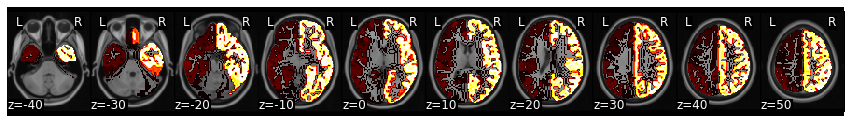

In [102]:
mask_fn = dpath+"glasser_masks.nii.gz"
mask = Brain_Data(mask_fn)
mask_x = expand_mask(mask)
mask.plot()


In [104]:
len(mask)


238955

In [24]:
##account for variation in how we saved out the outputs from the MVPA;
if q==1:
    output = Brain_Data(os.path.join(opath+'reslt_2_ROISearch+PP.nii.gz'))
if q==2 or q==3:
    output = Brain_Data(os.path.join(opath + 'q%s_reslt_2_ROISearch+PP.nii.gz'%q))

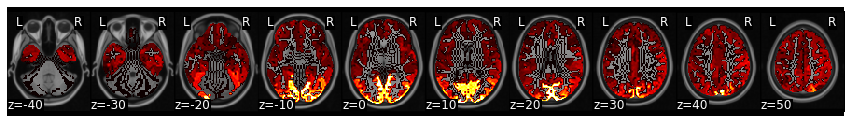

In [25]:
output.plot()

#### plotting out the differences between the three questions for this subject: 

1
2
3


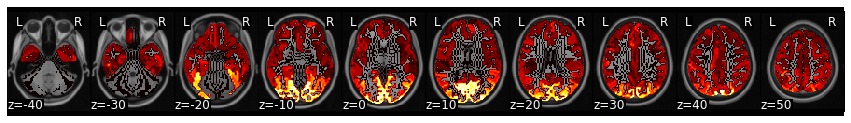

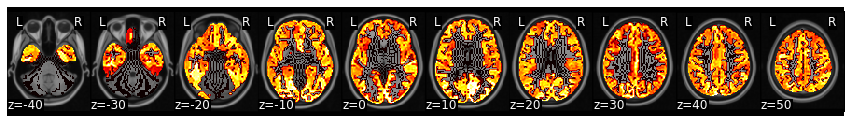

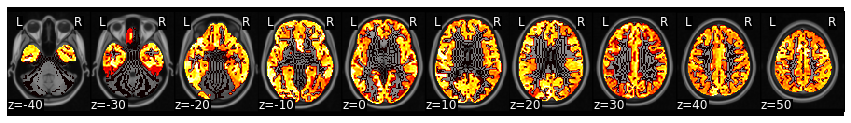

In [43]:
for qu in [1,2,3]: #questions 1, 2, 3
    print(qu)
    if qu==1:
        output = Brain_Data(os.path.join(opath+'reslt_2_ROISearch+PP.nii.gz'))
    if qu==2 or qu==3:
        output = Brain_Data(os.path.join(opath + 'q%s_reslt_2_ROISearch+PP.nii.gz'%qu))
    output.plot()
    

##### We confirmed that this is already in the format of mean activity for every voxel: 

In [146]:
print(len(output))
print(output.shape()) #voxels

238955
(238955,)


### Combining participants

In [44]:
#participants=['sub-rid000001', 'sub-rid000012 sub-rid000017 sub-rid000024 sub-rid000027 sub-rid000031 sub-rid000032 sub-rid000033 sub-rid000034 sub-rid000036 sub-rid000037 sub-rid000041"
              
participants = ['01','12','17', '24', '27', '31', '32', '33', '34', '36', '37', '41']

In [233]:
#for qu in [1,2,3]: #questions 1, 2, 3

for qu in [1]:
    combined = {} #a dictionary that I will add the participants to 
    #new dictionary per question
    bd_com = []
    for sub in participants:
        opath = "../../mvpc/sub-rid0000{}/".format(sub)
        if qu==1:
            output = Brain_Data(os.path.join(opath+'reslt_2_ROISearch+PP.nii.gz'))
        if qu==2 or qu==3:
            output = Brain_Data(os.path.join(opath + 'q%s_reslt_2_ROISearch+PP.nii.gz'%qu))
        ### creating a dictionary with all of the data values
        combined[sub] = output.data
        bd_com.append(output)
        ### since we are using Brain_Data objects, we can also preserve the mask information to make plotting easier
        ### Brain_Data objects support basic operations 
        

In [57]:
len(combined) #the dictionary is 12 subjects long- correct! 

12

In [234]:
total = 0
for ele in range(0, len(bd_com)):
    total = total + bd_com[ele]
avg = total/len(bd_com)    
avg.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

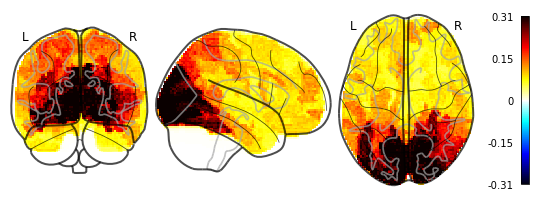

In [207]:
plot_glass_brain(avg.to_nifti(), colorbar=True, symmetric_cbar = True)


In [127]:
output

nltools.data.brain_data.Brain_Data(data=(238955,), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

### Question2: 

In [235]:
for qu in [2]:
    combined = {} #a dictionary that I will add the participants to 
    #new dictionary per question
    bd_com = []
    for sub in participants:
        opath = "../../mvpc/sub-rid0000{}/".format(sub)
        if qu==1:
            output = Brain_Data(os.path.join(opath+'reslt_2_ROISearch+PP.nii.gz'))
        if qu==2 or qu==3:
            output = Brain_Data(os.path.join(opath + 'q%s_reslt_2_ROISearch+PP.nii.gz'%qu))
        ### creating a dictionary with all of the data values
        combined[sub] = output.data
        bd_com.append(output)
        ### since we are using Brain_Data objects, we can also preserve the mask information to make plotting easier
        ### Brain_Data objects support basic operations 
total = 0
for ele in range(0, len(bd_com)):
    total = total + bd_com[ele]
avg_q2 = total/len(bd_com)    
avg_q2.iplot()      

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

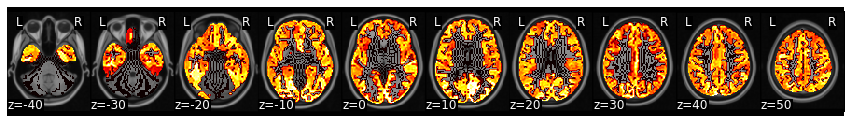

In [188]:
avg_q2.plot()

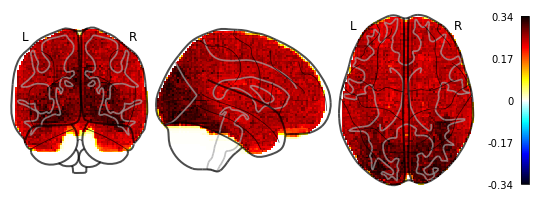

In [236]:
plot_glass_brain(avg_q2.to_nifti(), colorbar=True, symmetric_cbar = True)


## Question 3: 

In [232]:
for qu in [3]:
    combined = {} #a dictionary that I will add the participants to 
    #new dictionary per question
    bd_com = []
    for sub in participants:
        opath = "../../mvpc/sub-rid0000{}/".format(sub)
        if qu==1:
            output = Brain_Data(os.path.join(opath+'reslt_2_ROISearch+PP.nii.gz'))
        if qu==2 or qu==3:
            output = Brain_Data(os.path.join(opath + 'q%s_reslt_2_ROISearch+PP.nii.gz'%qu))
        ### creating a dictionary with all of the data values
        combined[sub] = output.data
        bd_com.append(output)
        ### since we are using Brain_Data objects, we can also preserve the mask information to make plotting easier
        ### Brain_Data objects support basic operations 
total = 0
for ele in range(0, len(bd_com)):
    total = total + bd_com[ele]
avg_q3 = total/len(bd_com)    
avg_q3.iplot()      

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

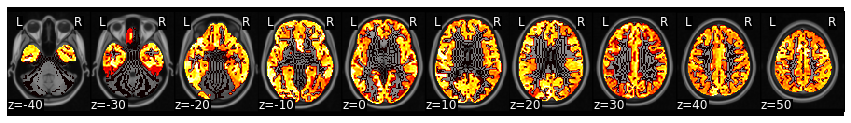

In [182]:
avg_q3.plot()

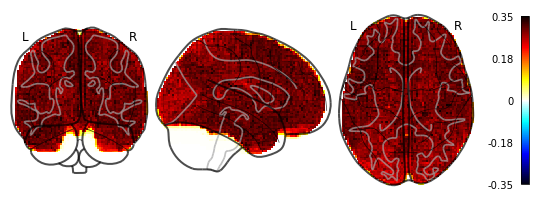

In [237]:
plot_glass_brain(avg_q3.to_nifti(), colorbar=True, symmetric_cbar = True)


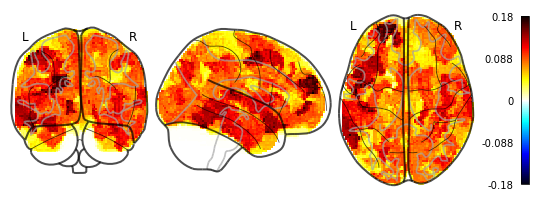

In [214]:
temp_diff = avg_q3-avg_q2
plot_glass_brain(temp_diff.to_nifti(), colorbar=True, symmetric_cbar = True)


### getting the summary stats:

In [238]:
for qu in [2]:
    combined = {} #a dictionary that I will add the participants to 
    #new dictionary per question
    bd_com = []
    for sub in participants:
        opath = "../../mvpc/sub-rid0000{}/".format(sub)
        if qu==1:
            output = Brain_Data(os.path.join(opath+'reslt_2_ROISearch+PP.nii.gz'))
        if qu==2 or qu==3:
            output = Brain_Data(os.path.join(opath + 'q%s_reslt_2_ROISearch+PP.nii.gz'%qu))
        ### creating a dictionary with all of the data values
        combined[sub] = output.data

In [239]:
combined

{'01': array([0.07581967, 0.07900216, 0.08882724, ..., 0.18589592, 0.19331985,
        0.1941511 ]),
 '12': array([0.08264398, 0.08458205, 0.0944876 , ..., 0.15546405, 0.15753889,
        0.16278968]),
 '17': array([0.07378139, 0.07662917, 0.08524109, ..., 0.21857942, 0.22812184,
        0.18132813]),
 '24': array([0.08474644, 0.08677283, 0.0975275 , ..., 0.18444406, 0.19467977,
        0.223875  ]),
 '27': array([0.08690487, 0.08932255, 0.10024285, ..., 0.16786315, 0.17899955,
        0.19513065]),
 '31': array([0.10002513, 0.1021124 , 0.11456379, ..., 0.17866269, 0.19329196,
        0.15404023]),
 '32': array([0.07593293, 0.07897074, 0.08808542, ..., 0.21310727, 0.23047655,
        0.23472275]),
 '33': array([0.09123885, 0.09445948, 0.10474992, ..., 0.21428661, 0.23346273,
        0.17536516]),
 '34': array([0.10429786, 0.10719673, 0.11937399, ..., 0.25752416, 0.27431827,
        0.22560036]),
 '36': array([0.06728766, 0.07018848, 0.07752503, ..., 0.16758999, 0.17823718,
        0.16

In [59]:
#for sub in participants:
    #mean = np.mean(np.vstack([combined[sub]]))

In [216]:
grouped = {} #open dictionary for adding the mean of each roi:
for sub in participants:
    for x in list(range(0,len(output.data))): #going across each node in the mask
        mean = np.mean((combined[sub][x])) #combined comes from above - it is all subjects' searchlight for one question
        grouped[x] = mean

In [94]:
len(grouped) #confirming that the dictionary we have made is the right value! 

238955